## NLP Twitch Channel Sentiment Analysis Project

By Sanil Katula, Jenil Rajeshkumar, Yulin Liu, Kerry Yu

### Overview
Live-streaming platforms have become a major part of online entertainment, with millions of users tuning in daily to watch their favorite streamers. Our goal in this project was to analyze the sentiment of chat messages in real-time on Twitch, one of the most popular platforms. The goal was to understand the emotional tone of the audience during live streams by applying natural language processing (NLP) tools. We collected chat messages from a selected Twitch channel, performed sentiment analysis, and visualized the results to gain insights into the audience’s mood during a particular time on a livestream. This report outlines our methodology, the tools used, the results obtained, and the conclusions drawn from the analysis.

In [ ]:
import os
import asyncio
import websockets
import json
import re
import nltk
import time
import matplotlib.pyplot as plt
import pandas as pd
from collections import deque
from nltk.sentiment import SentimentIntensityAnalyzer
from google.colab import output
import nest_asyncio


#!pip install transformers torch
#!pip install transformers
#!pip install websockets
#!pip install nltk
#!pip install wordcloud matplotlib
#!pip install ipywidgets


nltk.download('vader_lexicon')

nest_asyncio.apply()

sia = SentimentIntensityAnalyzer()

time_series_data = deque(maxlen=10000)

# from google.colab import userdata
# userdata.get('TWITCH_TOKEN')
# userdata.get('TWITCH_Client_ID')
# userdata.get('TWITCH_Authorization')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
import requests
import ipywidgets as widgets
from IPython.display import display

# Authorization = userdata.get('TWITCH_Authorization')
# Client_ID = userdata.get('TWITCH_Client_ID')

Authorization = '79lo3rwenntogjnwrvopiiwmeykx4r'
Client_ID = 'gp762nuuoqcoxypju8c569th9wz7q5'
TWITCH_TOKEN = 'oauth:qz24c4g5i57ixlr0h9yg2kf19e61nt'

HEADERS = {
    "Client-ID": Client_ID,
    "Authorization": f"Bearer {Authorization}"
}

def fetch_top_streamers():
    url = "https://api.twitch.tv/helix/streams"
    params = {"first": 10}
    response = requests.get(url, headers=HEADERS, params=params)

    if response.status_code == 200:
        data = response.json()
        return [stream["user_name"] for stream in data["data"]]
    else:
        print(f"❌ Error fetching streams: {response.status_code} - {response.json()}")
        return []

top_streamers = fetch_top_streamers()
top_streamers.insert(0, "Choose from Top Live...")

title = widgets.HTML("<h3>🔴 Analyze a Twitch Stream</h3>")

dropdown_label = widgets.Label("🎥 Top Live Streamers:")
dropdown = widgets.Dropdown(options=top_streamers, layout=widgets.Layout(width="50%"))

text_input_label = widgets.Label("🔍 Choose Your Own Streamer:")
text_input = widgets.Text(placeholder="Enter streamer name...", layout=widgets.Layout(width="50%"))

button = widgets.Button(description="✅ Select Streamer", button_style="success", layout=widgets.Layout(width="50%"))

output = widgets.Output()
TWITCH_CHANNEL = ""

def on_button_click(b):
    global TWITCH_CHANNEL
    with output:
        output.clear_output()
        if dropdown.value != "Choose from Top Live...":
            TWITCH_CHANNEL = f"#{dropdown.value}"
            print(f"✅ Twitch Channel set to: {TWITCH_CHANNEL}")
        elif text_input.value:
            TWITCH_CHANNEL = f"#{text_input.value}"
            print(f"✅ Twitch Channel set to: {TWITCH_CHANNEL}")
        else:
            print("⚠️ Please select or enter a streamer!")

button.on_click(on_button_click)

display(widgets.VBox([
    title,
    dropdown_label, dropdown,
    text_input_label, text_input,
    button,
    output
]))


In [ ]:
print (TWITCH_CHANNEL)

#summit1g


### Methodology
#### Data Collection and Cleaning
To achieve our goal, we first connected to Twitch’s IRC (Internet Relay Chat) using the WebSocket protocol. We selected a Twitch channel from a list of top live streamers or allowed users to input a custom channel name. Once connected, the script continuously listened for incoming messages, extracting relevant text data such as the username, message content, and timestamp, and storing it in a CSV file. We also implemented a reconnection mechanism to handle any unexpected disconnects.

In [ ]:
import asyncio
import websockets
import re
import pandas as pd
import os
import random
import time

TWITCH_IRC = "wss://irc-ws.chat.twitch.tv:443"

# Ensure the user has selected a Twitch channel
if not TWITCH_CHANNEL:
    raise ValueError("⚠️ ERROR: No Twitch channel selected! Please select or enter a streamer in the first cell.")

messages_data = []
MAX_MESSAGES = 10  # Adjust as needed

def parse_twitch_message(raw_msg):
    match = re.search(r":(.*?)!.*?@.*? PRIVMSG #(.*?) :(.*)", raw_msg)
    if match:
        username, channel, message = match.groups()
        return {"username": username, "channel": channel, "message": message.strip()}
    return None

def clean_message(msg):
    msg = msg.lower()  # Convert to lowercase
    msg = re.sub(r"http\S+", "", msg)  # Remove URLs
    msg = re.sub(r"@\w+", "", msg)  # Remove mentions
    msg = re.sub(r"[^a-zA-Z\s]", "", msg)  # Remove special characters, numbers, punctuation
    msg = " ".join(msg.split())  # Remove extra spaces
    return msg

async def process_message(ws, raw_msg):
    global messages_data
    parsed_msg = parse_twitch_message(raw_msg)

    if parsed_msg:
        cleaned_text = clean_message(parsed_msg["message"])
        if cleaned_text:  # Ignore empty messages
            messages_data.append({"username": parsed_msg["username"], "channel": parsed_msg["channel"], "message": cleaned_text})
            print(f"{parsed_msg['username']}: {cleaned_text}")

        if len(messages_data) >= MAX_MESSAGES:
            save_messages()
            await ws.close()

def save_messages():
    os.makedirs("data", exist_ok=True)
    df = pd.DataFrame(messages_data)
    df.to_csv("data/twitch_chat.csv", index=False)
    print("✅ Saved chat messages to data/twitch_chat.csv")

async def connect_to_twitch():
    while True:
        try:
            async with websockets.connect(TWITCH_IRC, ping_interval=15) as ws:
                await ws.send(f"PASS {TWITCH_TOKEN}")
                await ws.send("NICK justinfan123")
                await ws.send(f"JOIN {TWITCH_CHANNEL}")

                print(f"✅ Joined {TWITCH_CHANNEL} chat...")

                while len(messages_data) < MAX_MESSAGES:
                    response = await ws.recv()
                    await process_message(ws, response)

                save_messages()
                break

        except (websockets.exceptions.ConnectionClosed, ConnectionResetError) as e:
            wait_time = random.uniform(5, 15)
            print(f"⚠️ Connection lost: {e}. Reconnecting in {wait_time:.1f} seconds...")
            await asyncio.sleep(wait_time)

await connect_to_twitch()


✅ Joined #evelone2004 chat...
xyecoc2009: evelonbear
stereooo: tarelonchik
stereooo: tarelonchik
stereooo: tarelonchik
stereooo: tarelonchik
stereooo: tarelonchik
stereooo: tarelonchik
stereooo: tarelonchik
stereooo: tarelonchik
stereooo: tarelonchik
✅ Saved chat messages to data/twitch_chat.csv
✅ Saved chat messages to data/twitch_chat.csv


During the time we obtained our data set, we chose to extract our comments from the streamer CaseOh. We extracted around 2000 messages, which is controlled by the variable MAX_MESSAGES. We then saved the dataframe to our own personal computers.

In [ ]:
import pandas as pd

# Load Data
df = pd.read_csv("data/twitch_chat.csv")

from google.colab import files

df.to_csv("data.csv", index=False)  # Save as CSV without the index
files.download("data.csv")  # Download to your computer

# Show first few rows
print(df.head())

FileNotFoundError: [Errno 2] No such file or directory: 'data/twitch_chat.csv'

# Labeling and Cleaning Data
We then put the downloaded data set into a google sheet so that everyone could help label all of the comments of each comment manually. For example, for a row that contains a comment "Good to see you", we would enter into the newly created "response" column "positive" in the row where the comment lies.

After we labeled up to around 2000 rows of data, we reimport the data set into the google colab to clean up the twitch comments up. We converted everything to lower case, removed mentions of anybody's username, and shortened phrases that have repeated letters to help remove things that are irrevelant in determining a comments sentiment.

In [ ]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords

nltk.download("stopwords")

sheet_url = "https://docs.google.com/spreadsheets/d/1rIqHs9DNpnee-FrudynBByx_j_YfSx5gjE8FSoCI_kw/export?format=csv"
df = pd.read_csv(sheet_url)


df = df.dropna(subset=["response"])

def clean_message(msg):
    msg = str(msg).lower().strip()  # Convert to lowercase
    msg = re.sub(r"http\S+", "", msg)  # Remove URLs
    msg = re.sub(r"@\w+", "", msg)  # Remove mentions
    msg = re.sub(r"[^a-zA-Z\s]", "", msg)  # Remove special characters, numbers, punctuation
    msg = " ".join([word for word in msg.split() if word not in stopwords.words("english")])  # Remove stopwords
    msg = re.sub(r'(.)\1+', r'\1', msg)    # Remove repeated characters (e.g., "loooool" → "lol")
    return msg


df["cleaned_message"] = df["message"].apply(clean_message)

from google.colab import files

# Save DataFrame as CSV
df.to_csv("caseoh.csv", index=False)

# Download the file
files.download("caseoh.csv")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Exploratory Data Analysis

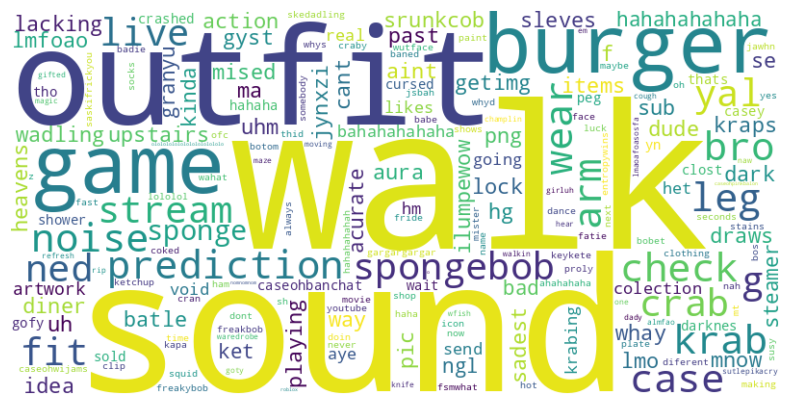

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Join all the messages into a single string
text = ' '.join(df['cleaned_message'].astype(str))

# Remove duplicate words by converting text into a set and back into a string
unique_words_text = ' '.join(set(text.split()))

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(unique_words_text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Below is an implementation of a word cloud visualization while ensuring that no words are repeated. A word cloud is a visual representation of textual data where the frequency of words determines their size in the image. However, in some cases, repetitive words can clutter the visualization and make it less informative. To address this issue, the following modifications were applied:

Removal of duplicate words ensures each word appears only once.
The processed text is then used to generate a cleaner and more meaningful word cloud.

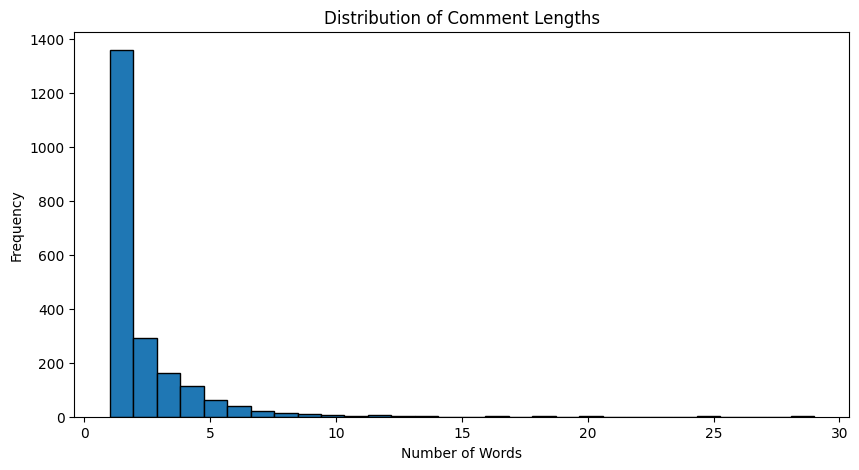

In [ ]:
df['comment_length'] = df['message'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 5))
plt.hist(df['comment_length'], bins=30, edgecolor='black')
plt.title('Distribution of Comment Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()



We could see from the plot above that the most comments are very short. This makes sense since Twitch culture is centered around emotes and slangs such as "Pog" or "Kappa".

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


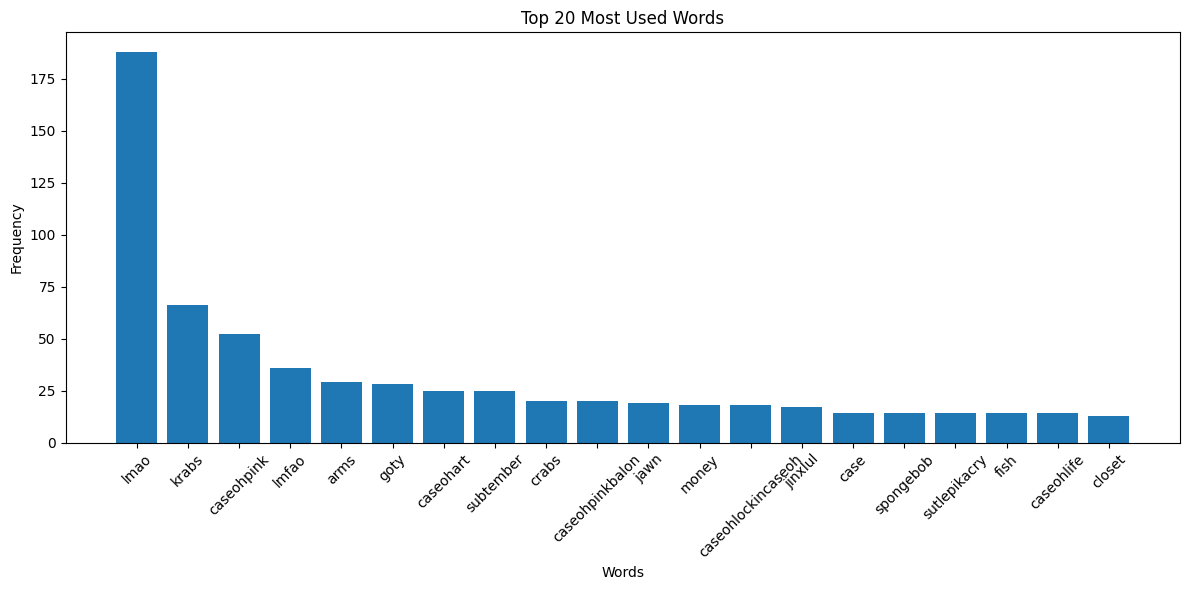

In [ ]:
import nltk

# Download the required NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')  # Download punkt_tab resource

import matplotlib.pyplot as plt

from nltk.corpus import stopwords

from nltk.tokenize import word_tokenize
import string

from collections import Counter

# Combine all comments into a single string
all_text = " ".join(comment.lower() for comment in df['cleaned_message'])

# Tokenization and cleaning
stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)

# Tokenize words
tokens = word_tokenize(all_text)

# Filter out tokens that are 1 character long
tokens = [word for word in tokens if len(word) > 3]

tokens_to_remove = ['thats', 'like']

# Filter out the tokens that are in the tokens_to_remove list
tokens = [word for word in tokens if word not in tokens_to_remove]


# Normalize tokens: lowercase, remove punctuation
cleaned_tokens = [word.lower().strip(string.punctuation) for word in tokens]

stop_words = set(stopwords.words('english'))

# Remove stop words from the token list
filtered_tokens = [word for word in cleaned_tokens if word not in stop_words]


# Count the frequencies of each word
word_counts = Counter(filtered_tokens)

# Get the top 20 most common words (or fewer if there aren't 20)
top_words = word_counts.most_common(20)
words, counts = zip(*top_words)

# Create a bar chart of the top words
plt.figure(figsize=(12, 6))
plt.bar(words, counts)
plt.title('Top 20 Most Used Words')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)  # Rotate word labels for better readability
plt.tight_layout()       # Adjust layout for neatness
plt.show()

"krabs", "crabs", "spongebob", "goty" are among the top 20 most used words, indicating that the streamer is playing a game related to SpongeBob.

words that starts with "caseoh" are twitch emojis. Twitch emojis are often entered many times (spammed) in a comment so it is not surprising many emojis appeared in this plot.

# Visualize Current Sentiment Proportion

If we construct a pie plot of all of the categories in our "response" column, we see that 38% are positive, 37% are neutral, and 19% are negative. The rest are very negative and very positive and postive. These miniority labels were probably a mistake. Plus they will be underprepresented if we use these labels to traine the model. So we will just convert them to negative if it is very negative or positive if it is very positive.

The current proportion of sentiments are not very balanced. But we believe that if we were to perform balancing by downsampling, we would have too few observations to train a strong model.

response
positive         800
neutral          781
negative         396
very positive    106
postive           12
very negative      3
Name: count, dtype: int64


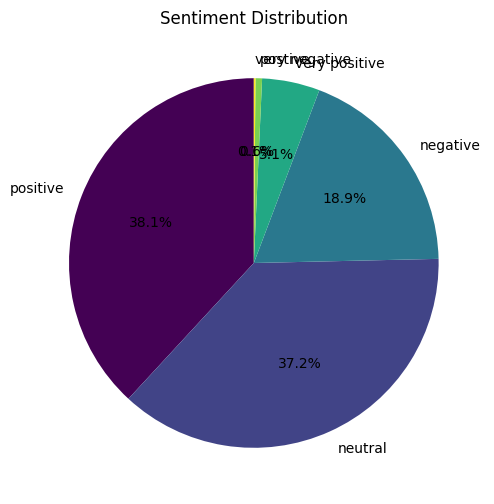

In [ ]:

sentiment_counts = df["response"].value_counts()


sentiment_percentage = df["response"].value_counts(normalize=True) * 100
print(sentiment_counts)

import matplotlib.pyplot as plt

# Plot sentiment distribution
plt.figure(figsize=(6,6))
sentiment_counts.plot(kind="pie", autopct="%1.1f%%", startangle=90, cmap="viridis")
plt.ylabel("")  # Hide y-label
plt.title("Sentiment Distribution")
plt.show()

df["response"] = df["response"].replace({
    "very positive": "positive",
    "very negative": "negative",
    "postive": "positive"
})



# Loading a Pretrained Model

Now that our data set is cleaned up, our next step is to fit the data into our model. But before performing any training, we want to first see how well would a pretrained model would do without any training or fine tuning. We will be using a pretrained Roberta Model that is trained on 58 million tweets. We access it through the pipepline() and apply the model to every messages in the data set. The model will either output a confidence score and a label that it decides through its own custom threshold. We extract the label and then make all of the outputs lowercase before putting them into a new column in the data frame called predicted_sentiment.

# Predict Sentiment for Twitch Chat

In [ ]:
import torch

from transformers import pipeline

device = 0 if torch.cuda.is_available() else -1

sentiment_model = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment", device=device)


df["predicted_sentiment"] = df["cleaned_message"].apply(lambda x: sentiment_model(x)[0]["label"])

sentiment_map = {"POSITIVE": "positive", "NEGATIVE": "negative"}
df["predicted_sentiment"] = df["predicted_sentiment"].map(sentiment_map).fillna("neutral")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Device set to use cpu


# Evaluate Pretrained Model Accuracy

By using a model trained from 58 million tweets, we were able to get an accuracy of 37% if we compare its predictions to our labels.

However, if we look at the predicted_sentiment, almost everything is neutral. It seems like the accuracy was this high only because 37% represents the percentage of response we manually labeled as neutral.

This might be because since the model is trained on Tweets, it is not well-tuned for Twitch-specific language, slang, or tone. It could also be the case that the comments are not negative or positive enough to get a high sentiment intensity for the pretrained model to choose a non neutral response.

In [ ]:
from sklearn.metrics import accuracy_score

 accuracy = accuracy_score(df["response"], df["predicted_sentiment"])
print(f"Model Accuracy: {accuracy:.2f}")


import pandas as pd
random_seed = 42
# Select 10 random rows
random_rows = df.sample(n=5)[["cleaned_message", "response", "predicted_sentiment"]]


print(random_rows)


Model Accuracy: 0.37
     cleaned_message  response predicted_sentiment
36              bruh  negative             neutral
113             lmao  positive             neutral
54            jawewn  positive             neutral
873                g  positive             neutral
1981               g  positive             neutral



# Fine Tune Roberta Model

Given the limitations of the pretrained RoBERTA, which is a widely used sentiment analysis model on Twitch-specific language and nuances, we now proceed to fine tune a pretrained model.

**Label Mapping:**
1. Since the responses are categorical (positive, neutral, negative), we map them to numerical values.
2. This numerical representation is required for training a classifier.


In [ ]:
# import pandas as pd
# import re

# sheet_url = "https://docs.google.com/spreadsheets/d/1rIqHs9DNpnee-FrudynBByx_j_YfSx5gjE8FSoCI_kw/export?format=csv"
# df = pd.read_csv(sheet_url)

# df["cleaned_message"] = df["message"].apply(clean_message)
# df = df.dropna(subset=["response"])


**Splitting the Data**

 The data is split into training and testing subsets (80/20 split) to allow us to train the model on one portion and evaluate it on unseen data.


In [ ]:
sentiment_map = {"positive": 2, "neutral": 1, "negative": 0}
df["label"] = df["response"].map(sentiment_map)

NameError: name 'df' is not defined

In [ ]:
from sklearn.model_selection import train_test_split

train_texts, test_texts, train_labels, test_labels = train_test_split(
    df["cleaned_message"],  # Input text
    df["label"],            # Target labels
    test_size=0.2,          # 20% Test, 80% Train
    random_state=42         # Ensures reproducibility
)

print(f"✅ Data Split Completed: {len(train_texts)} Training | {len(test_texts)} Testing")


**Fine Tune Roberta**

Before we perform any fine tuning, we must prepare the data by creating LabelEncoder, which is used to convert non-numeric responses (such as "Yes" or "No") into numeric values (like 1 and 0). The data includes messages and corresponding responses, which are categorized as "Yes" or "No." The LabelEncoder is used to convert these categorical responses into numbers, creating a new column called "response_encoded."

Next, the code splits the data into two sets: a training set and a testing set. The training set (80% of the data) is used to teach the machine learning model, while the testing set (20% of the data) is used to evaluate how well the model has learned.

This split ensures that the model can be trained on one portion of the data and then tested on another portion to check its accuracy and performance

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Encode responses if they are categorical
label_encoder = LabelEncoder()
df["response_encoded"] = label_encoder.fit_transform(df["response"])

# Split into train and test sets
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df["cleaned_message"].tolist(),
    df["response_encoded"].tolist(),
    test_size=0.2,
    random_state=42
)


**Tokenization**

We continue with more data processing in the code below.

We use the RoBERTa tokenizer from the Hugging Face Transformers library to preprocess text data for a machine learning model.

The tokenizer is loaded using RobertaTokenizer.from_pretrained("roberta-base"), ensuring it aligns with the RoBERTa model’s pre-trained vocabulary.

The train_texts and val_texts datasets are then tokenized with truncation (to limit sequences to 512 tokens) and padding (to standardize input lengths), making them suitable for model training.


In [ ]:
from transformers import RobertaTokenizer

# Load the tokenizer
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

# Tokenize the text
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=512)


import os
os.environ["WANDB_MODE"] = "disabled"


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

**Creating a PyTorch Dataset**

For the next step, we use a custom PyTorch Dataset class (TwitchDataset) to handle tokenized text data for model training.

Then we create training and validation datasets (train_dataset, val_dataset) using preprocessed encodings and labels, preparing them for use with a PyTorch DataLoader during model training.

In [ ]:
import torch

class TwitchDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            "input_ids": torch.tensor(self.encodings["input_ids"][idx]),
            "attention_mask": torch.tensor(self.encodings["attention_mask"][idx]),
            "labels": torch.tensor(self.labels[idx]),
        }

# Convert to PyTorch Dataset
train_dataset = TwitchDataset(train_encodings, train_labels)
val_dataset = TwitchDataset(val_encodings, val_labels)




**Model Training**

We load the pretrained RoBERTa model with a classification head and set up the training configuration. Using Hugging Face’s Trainer API, we fine-tune the model on our training data and evaluate it on our validation data.

In [ ]:
# from transformers import RobertaForSequenceClassification, Trainer, TrainingArguments

# # Load pre-trained RoBERTa with a classification head
# num_labels = len(label_encoder.classes_)
# model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=num_labels)

# # Define training arguments
# training_args = TrainingArguments(
#     output_dir="./results",
#     evaluation_strategy="epoch",
#     per_device_train_batch_size=8,
#     per_device_eval_batch_size=8,
#     num_train_epochs=3,
#     weight_decay=0.01,
#     logging_dir="./logs",
#     logging_steps=10,
# )

# # Initialize Trainer
# trainer = Trainer(
#     model=model,
#     args=training_args,
#     train_dataset=train_dataset,
#     eval_dataset=val_dataset,
# )




# # Train the model
# trainer.train()


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

Now onto the fine tuning step.

We load the **pre-trained RoBERTa model** (`"roberta-base"`) with a classification head.

To enhance model regularization and prevent overfitting, dropout rates for both the hidden layers and attention layers are increased to 0.3 (default is 0.1). These adjustments help the model generalize better, especially since we are only working with around 2000 observations.

We then define training arguments using `TrainingArguments`, to customize the hyperparameters for optimization.

We set `num_train_epochs=5` to allow the model to train for multiple iterations

We set `learning_rate=2e-5` to allow for more stable learning and slow or reduce overfitting.

We also incorparted `EarlyStoppingCallback`,  to make sure that training stops automatically if the validation loss does not improve for two consecutive epochs

Finally, the Hugging Face `Trainer` API is used to handle model training and evaluation in later steps

Once the setup is complete, we run `trainer.train()` to start fine tuning the pretrained RoBERTA model.

In [ ]:
from transformers import RobertaForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback

# Load pre-trained RoBERTa with a classification head
num_labels = len(label_encoder.classes_)
model = RobertaForSequenceClassification.from_pretrained(
    "roberta-base",
    num_labels=num_labels
)

# Increase dropout to prevent overfitting
model.config.hidden_dropout_prob = 0.3  # Default is 0.1, increase to 0.3-0.5
model.config.attention_probs_dropout_prob = 0.3

# Define Training Arguments (Fixed Deprecated Warning)
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",  # ✅ Changed from `evaluation_strategy` to `eval_strategy`
    save_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,  # Train for more epochs
    learning_rate=2e-5,  # Reduce from default 5e-5
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    save_total_limit=2,  # Keep only 2 best models
    load_best_model_at_end=True,  # Restore best checkpoint
)

# Add Early Stopping Callback
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]  # Stop if no improvement in 2 epochs
)

# Train the model
trainer.train()


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

In [ ]:
# Save model and tokenizer after training
model.save_pretrained("twitch_roberta")
tokenizer.save_pretrained("twitch_roberta")


('twitch_roberta/tokenizer_config.json',
 'twitch_roberta/special_tokens_map.json',
 'twitch_roberta/vocab.json',
 'twitch_roberta/merges.txt',
 'twitch_roberta/added_tokens.json')

**Get Accuracy**

Once the model is fine-tuned, we compute the validation accuracy by making predictions on our validation set and comparing them with the true labels.

In [ ]:
from sklearn.metrics import accuracy_score

# Get predictions
preds = trainer.predict(val_dataset).predictions
preds = preds.argmax(axis=1)  # Convert logits to label predictions

# Compute accuracy
accuracy = accuracy_score(val_labels, preds)
print(f"Validation Accuracy: {accuracy:.4f}")


Validation Accuracy: 0.6500


**Make Predictions Using Fine Tuned Roberta Model**

Finally, we demonstrate how to load the fine-tuned model and tokenizer to predict the sentiment of new messages.

The function below tokenizes multiple input messagees, pass them through the model, and returns the predicted sentiment classes

In [ ]:
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Define the same label classes used during training
label_encoder = LabelEncoder()
label_encoder.classes_ = np.array(["negative", "neutral", "positive"])  # Ensure it's an array

# Convert the prediction to a NumPy array and decode it
decoded_label = label_encoder.inverse_transform(np.array([predicted_label]))[0]

print(f"Predicted Class: {decoded_label}")


Predicted Class: neutral


In [ ]:
def predict_batch(messages):
    inputs = tokenizer(messages, return_tensors="pt", truncation=True, padding=True, max_length=512)

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    predicted_classes = torch.argmax(logits, dim=1).tolist()

    return predicted_classes

# Example usage
messages = ["Wow, that was insane!", "lol", "GG", "ew", "best streamer", "what a joke"]
predicted_labels = predict_batch(messages)

# Decode labels
decoded_labels = label_encoder.inverse_transform(predicted_labels)
print(f"Predicted Classes: {decoded_labels}")


Predicted Classes: ['neutral' 'neutral' 'neutral' 'neutral' 'neutral' 'neutral']


# Conclusion

This project embarked on a journey to build a robust sentiment analysis system specifically tailored for Twitch chat. We began by leveraging an API to load a substantial corpus of Twitch messages, which we initially analyzed using a pretrained model—originally trained on 58 million tweets. This model, however, only achieved a 37% accuracy, with most predictions falling into the neutral category. It became evident that a tweet-trained model struggles with Twitch-specific language, slang, and nuances, often misclassifying the varied expressions of sentiment.

Recognizing these limitations, we proceeded to fine-tune a RoBERTa model using manually labeled data. This process involved several key steps:
- **Label Mapping:** Converting categorical sentiment labels (positive, neutral, negative) into numerical values essential for training.
- **Data Splitting:** Dividing the dataset into training and validation sets (80/20 split) to ensure robust evaluation.
- **Tokenization & Dataset Creation:** Using the RoBERTa tokenizer to prepare our text data and creating a custom PyTorch dataset for streamlined training.
- **Fine-Tuning:** Training the RoBERTa model over multiple epochs, which resulted in an improved validation accuracy of 65%.

While the fine-tuned model marked a significant improvement, it still faced challenges. The model's performance varied when applied to different Twitch channels, as each channel exhibited unique language styles and audience behaviors. This variability underscored the difficulty of generalizing sentiment analysis across diverse online communities.

In summary, our work highlights both the progress made and the challenges that remain:
- **Successes:**  
  - Transitioning from a generic tweet-based model to a fine-tuned, domain-specific RoBERTa model led to improved accuracy.
  - Careful data preprocessing and domain adaptation strategies played a critical role in enhancing performance.

- **Challenges:**  
  - The inherent differences in language and sentiment expression across Twitch channels mean that even a fine-tuned model may struggle with generalization.
  - Manual labeling and data collection remain resource-intensive, limiting our ability to capture the full diversity of Twitch interactions.

Looking forward, future work should focus on expanding the dataset to include a broader range of channels, exploring advanced domain adaptation techniques, and possibly developing channel-specific models. These steps could further refine the model’s ability to understand and predict the dynamic and varied sentiments of Twitch audiences.
